# Classification CAH

In this notebook, the 24-hour flight data is used to conduct the classification.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from scipy.cluster.hierarchy import ward, fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingClassifier


In [87]:
%run ../flight\ phase\ on\ dataset/db.py
df = db_to_pandas(filename='descriptors_meteo.db')

In [149]:
%run Feature_Selection.py
columns_remained = threshold_selection(begin=-1, end=1, n_choices=10)

number of evaluation is 1
number of evaluation is 2
number of evaluation is 3
number of evaluation is 4
number of evaluation is 5
number of evaluation is 6
number of evaluation is 7
number of evaluation is 8


In [86]:
columns_remained

Index(['avg_vertrate_speed_descent', 'std_vertrate_speed_descent',
       'min_vertrate_speed_descent', 'temp_c_descent', 'dewpoint_c_descent',
       'min_spd_cruise', 'mean_altitude_cruise', 'avg_vertrate_speed_climb',
       'std_vertrate_speed_climb', 'min_spd_climb', 'temp_c_climb',
       'dewpoint_c_climb'],
      dtype='object')

In [88]:
df.drop(columns=['icao', 'icao_airline', 'duration_descent', 'duration_cruise', 'duration_climb', 'airport_climb', 'airport_descent'],inplace=True)

In [89]:
df.dropna(subset = ['airline'], inplace = True)

In [91]:
# Here categorical codes are added in the dataframe for airlines
df["airline"] = df["airline"].astype('category')
df["airline_cat"]=df["airline"].cat.codes
df_noairline = df.drop(columns=['airline'])
df_noairline.set_index('flight_id',inplace=True)

In [92]:
# The dictionary of airline and their codes
airlines_decoder = dict(enumerate(df["airline"].cat.categories))

In [93]:
df_noairline.describe()

,avg_speed_descent,std_speed_descent,avg_vertrate_speed_descent,std_vertrate_speed_descent,max_spd_descent,min_spd_descent,max_vertrate_speed_descent,min_vertrate_speed_descent,temp_c_descent,dewpoint_c_descent,...,avg_vertrate_speed_climb,std_vertrate_speed_climb,max_spd_climb,min_spd_climb,max_vertrate_speed_climb,min_vertrate_speed_climb,temp_c_climb,dewpoint_c_climb,wind_spind_kt_climb,airline_cat
count,6249.000000,6249.000000,6249.000000,6249.000000,6249.000000,6249.000000,6249.000000,6249.000000,1026.000000,1026.000000,...,7194.000000,7194.000000,7194.000000,7194.000000,7194.000000,7194.000000,1117.000000,1117.000000,1117.000000,11263.000000
mean,155.432029,51.311277,-7.581051,7.200145,225.490411,70.876099,-0.329963,-40.557510,3.011014,-0.446004,...,10.133301,7.540315,234.183098,77.481243,40.076988,1.349547,3.129185,-0.104297,8.246195,58.311462
std,18.951226,11.994864,4.352093,19.416473,31.301989,19.526216,1.077078,127.455623,11.937310,11.292624,...,5.062158,20.289679,23.909701,15.569619,118.313990,1.807393,11.728595,10.917943,5.098430,40.364383
min,62.109583,0.000000,-108.208000,0.000000,66.150000,0.000000,-11.050000,-1678.310000,-29.000000,-34.000000,...,3.387368,0.000000,82.440000,0.000000,5.530000,-33.160000,-26.000000,-30.000000,0.000000,0.000000
25%,142.524179,44.652905,-7.786267,2.998407,211.170000,61.200000,-0.330000,-19.830000,-6.000000,-9.000000,...,8.238544,3.685444,219.420000,69.332500,17.560000,0.000000,-6.000000,-8.000000,4.000000,14.000000
50%,154.167273,51.210551,-6.886429,3.606299,224.480000,65.090000,0.000000,-15.610000,6.000000,4.000000,...,9.383148,4.150623,233.970000,75.620000,19.510000,0.650000,6.000000,4.000000,8.000000,65.000000
75%,167.154286,58.256858,-6.116111,4.378183,239.270000,70.450000,0.000000,-12.680000,13.000000,9.000000,...,10.660104,4.667277,247.990000,82.190000,21.780000,2.280000,13.000000,9.000000,11.000000,104.000000
max,295.265467,413.283756,-1.780000,362.994481,1774.180000,219.470000,5.850000,-1.950000,34.000000,24.000000,...,87.289167,267.706896,743.540000,167.100000,1346.840000,14.960000,34.000000,27.000000,29.000000,118.000000


In [146]:
columns = df_noairline.columns

<div class="alert alert-block alert-warning">
<b>Hypothesis:</b> Only airlines with 10 logs or more are eligible for classification. So others will be excluded in the following analysis procedure.
</div>

In [12]:
filt_10log = df_noairline['airline_cat'].value_counts()>=10

In [13]:
airline_list_cat = filt_10log[filt_10log.values==True].index

In [14]:
df_filt_10log = df_noairline[df_noairline['airline_cat'].isin(airline_list_cat)]

# Correlation between features

In [16]:
corr_matrix = df_filt_10log.corr(method='spearman')

In [17]:
(corr_matrix[(corr_matrix>0.5) | (corr_matrix<-0.5)].count().sum() - corr_matrix.columns.shape[0])/2

39.0

There exists several couples (39) of variables that are highly correlated, with a coefficient of correlation superior to 0.5. A feature selection process needs to be conducted.

In [96]:
# Standard Scaling (not necessary for random forest)
feature_selection_df = df_filt_10log.dropna()
X = feature_selection_df.iloc[:,:-1]
y = feature_selection_df.loc[:,["airline_cat"]]
X_full = df_filt_10log.iloc[:,:-1]
y_full = df_filt_10log.loc[:,["airline_cat"]]

In [94]:
X_full_selected = X_full[columns_remained]

In [97]:
X_full_selected

,avg_vertrate_speed_descent,std_vertrate_speed_descent,min_vertrate_speed_descent,temp_c_descent,dewpoint_c_descent,min_spd_cruise,mean_altitude_cruise,avg_vertrate_speed_climb,std_vertrate_speed_climb,min_spd_climb,temp_c_climb,dewpoint_c_climb
flight_id,,,,,,,,,,,,
1,-7.088400,3.912235,-16.26,NaN,NaN,243.97,11887.424118,7.977123,4.183138,73.37,NaN,NaN
2,-8.526885,3.483607,-21.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-9.011304,4.909492,-19.83,NaN,NaN,216.32,10971.657000,NaN,NaN,NaN,NaN,NaN
4,-9.560270,4.882914,-20.48,23.0,16.0,215.97,10973.525714,NaN,NaN,NaN,NaN,NaN
5,-6.169405,3.517790,-14.31,NaN,NaN,NaN,NaN,7.802778,3.930737,64.39,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
11534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.267222,4.167291,83.75,21.0,13.0
11535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.695714,4.629653,90.70,NaN,NaN
11536,-5.053077,3.101744,-14.96,NaN,NaN,222.88,8870.026364,9.490000,4.674674,83.33,NaN,NaN


# Aggregating data

In [99]:
new_df = pd.merge(X_full_selected, y_full, how = 'left', left_index = True, right_index = True)

In [101]:
df_median = new_df.groupby(by = 'airline_cat').median()

In [102]:
df_median.dropna(inplace=True)

In [103]:
df_median.columns

Index(['avg_vertrate_speed_descent', 'std_vertrate_speed_descent',
       'min_vertrate_speed_descent', 'temp_c_descent', 'dewpoint_c_descent',
       'min_spd_cruise', 'mean_altitude_cruise', 'avg_vertrate_speed_climb',
       'std_vertrate_speed_climb', 'min_spd_climb', 'temp_c_climb',
       'dewpoint_c_climb'],
      dtype='object')

In [104]:
df_median_values = df_median.values
scaler = RobustScaler().fit(df_median_values)
df_median_scaled = scaler.fit_transform(df_median_values)
df_median_scaled = pd.DataFrame(df_median_scaled)

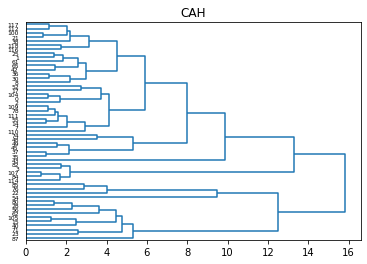

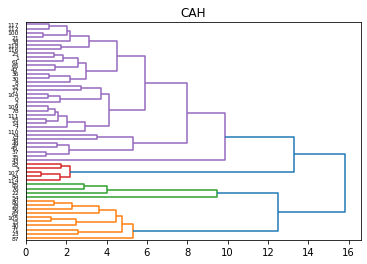

In [106]:
Z = linkage(df_median_scaled,method='ward',metric='euclidean')
threshold = 11
plt.title("CAH")
dendrogram(Z,labels=df_median.index,orientation='right',color_threshold=0)
plt.show()
plt.title('CAH')
dendrogram(Z,labels=df_median.index,orientation='right',color_threshold=threshold)
plt.show()

In [107]:
import numpy as np
import pandas
groupes_cah = fcluster(Z,t=threshold,criterion='distance')
print(groupes_cah)

[4 4 4 3 4 4 4 1 4 4 2 1 4 1 4 4 4 4 4 1 4 4 4 4 4 4 2 4 1 4 1 4 1 4 2 4 1
 3 3 2 1 4 4 1 3 4 4 4 4 3 4 4 4]


In [108]:
idg = np.argsort(groupes_cah)
df1 = pandas.DataFrame(df_median.index[idg],groupes_cah[idg])
df2 = pd.DataFrame.from_dict(airlines_decoder, orient='index')

In [109]:
pd.merge(df1, df2, how = 'left', left_on = 'airline_cat', right_index = True)

,airline_cat,0
1,56,Iberia Express
1,71,Nepal Airlines
1,80,Qatar Airways
1,40,China Southern Airlines
1,87,Saudia
1,15,Air Fret Senegal
1,62,Kuwait Airways
1,28,Asiana Airlines
1,105,Turkish Airlines
1,23,Airblue


In [124]:
df_median['group'] = groupes_cah
df_median_scaled['group'] = groupes_cah
feature_diff = df_median_scaled.groupby('group').median().std()

In [132]:
idx = feature_diff.sort_values(ascending=False).index

In [144]:
columns_sorted = np.take(np.array(columns_remained),idx)

In [145]:
# sort the result by the importance of features
df_median.groupby('group').median().loc[:,columns_sorted]

,min_spd_cruise,dewpoint_c_descent,dewpoint_c_climb,temp_c_climb,temp_c_descent,mean_altitude_cruise,std_vertrate_speed_descent,avg_vertrate_speed_descent,std_vertrate_speed_climb,min_vertrate_speed_descent,avg_vertrate_speed_climb,min_spd_climb
group,,,,,,,,,,,,
1,221.4425,11.75,12.00,18.5,18.25,9877.599013,3.244489,-6.238604,3.986603,-13.9825,9.202537,82.3675
2,246.4250,18.50,12.25,16.5,23.25,11429.839579,4.101792,-7.566439,3.667352,-18.2100,8.068712,79.6225
3,220.8500,-16.00,-15.00,-13.0,-13.50,10894.807059,3.055014,-6.262989,3.723535,-13.9800,8.003289,77.6150
4,216.9350,6.00,5.50,8.5,7.00,11380.095551,4.054295,-7.215410,4.427346,-17.1500,10.043859,74.5450
